# Data Wrangling Project Script

This script will cover all data wrangling steps - generating summary statistics, looking for missing data and outliers, and cleaning/transforming data when needed. 

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.json import json_normalize
import seaborn as sns
#allow all columns to be viewed:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [ ]:
#Check current path
current_path = % pwd
#print(current_path)

In [ ]:
#If current_path is in Scripts folder, 
#go up one level so we can open the data folder
if (current_path.rsplit('\\', 1)[1] == 'Scripts'):
    % cd ..
    #% pwd

## AirBnB Dataset Analysis

### Read in Listings

The AirBnB data comes in multiple files. The I plan to use for this project is listings.csv, which contains detailed information on all of the rentals listed in a city. The data comes from InsideAirBnB (http://insideairbnb.com/about.html#disclaimers) and can be downloaded for specific cities. I have decided to use the city of Toronto, so this version of listings.csv only contains data for Toronto. 

In [4]:
#Read in AirBnB listing data for Toronto
path='../Capstone/Data/listings.csv'
abb_list = pd.read_csv(path)

In [5]:
#View shape of abb_list
abb_list.shape

(17542, 96)

The listings dataset has 17,542 records and 96 columns. 

In [6]:
#View first 5 rows of dataset
abb_list.head(3)

id                         listing_url       scrape_id last_scraped  \
0   1419   https://www.airbnb.com/rooms/1419  20180808031137   2018-08-08   
1   8077   https://www.airbnb.com/rooms/8077  20180808031137   2018-08-08   
2  10314  https://www.airbnb.com/rooms/10314  20180808031137   2018-08-08   

                                 name  \
0     Beautiful home in amazing area!   
1  Downtown Harbourfront Private Room   
2          Union Inn II (Leslieville)   

                                             summary  \
0  This large, family home is located in one of T...   
1  Guest room in a luxury condo with access to al...   
2  We offer a private room for two with a queen b...   

                                               space  \
0  Visit Toronto with this fabulous furnished hom...   
1  My husband and I are both artists. I give pain...   
2  The 'union inn' offers a clean, spacious room ...   

                                         description experiences_offered  \
0  This large, family home is located in one of T...                none   
1  Guest room in a luxury condo with access to al...                none   
2  We offer a private room for two with a queen b...                none   

                               neighborhood_overview  \
0  The apartment is located in the Ossington stri...   
1                                                NaN   
2  Our charming adopted home of Leslieville is a ...   

                                               notes  \
0  To learn a little more about our home, see: (U...   
1                                                NaN   
2  Clean towels, a hair dryer, soap and sanitary ...   

                                             transit  \
0  All forms of public transportation are easily ...   
1                                                NaN   
2  Our home is steps from street car and bus acce...   

                                              access  \
0          The whole house and garden are available.   
1                                                NaN   
2  We have high speed wireless internet for your ...   

                                         interaction  \
0  We will be out of town, but fully accessible b...   
1                                                NaN   
2  We love meeting new people. However we do work...   

                                         house_rules  thumbnail_url  \
0  This is our much-loved family home. We expect ...            NaN   
1                                 No smoking please.            NaN   
2  When we travel on airbnb we behave as we would...            NaN   

   medium_url                                        picture_url  \
0         NaN  https://a0.muscache.com/im/pictures/76206750/d...   
1         NaN  https://a0.muscache.com/im/pictures/11780344/1...   
2         NaN  https://a0.muscache.com/im/pictures/53300435/4...   

   xl_picture_url  host_id                                 host_url  \
0             NaN     1565   https://www.airbnb.com/users/show/1565   
1             NaN    22795  https://www.airbnb.com/users/show/22795   
2             NaN    35505  https://www.airbnb.com/users/show/35505   

         host_name  host_since             host_location  \
0        Alexandra  2008-08-08  Toronto, Ontario, Canada   
1   Kathie & Larry  2009-06-22  Toronto, Ontario, Canada   
2  Douglas & Annie  2009-09-01  Toronto, Ontario, Canada   

                                          host_about host_response_time  \
0  I live in Toronto, Canada with my husband and ...                NaN   
1  My husband and I have been airbnb host for alm...                NaN   
2  We are a couple of architects who try to make ...                NaN   

  host_response_rate  host_acceptance_rate host_is_superhost  \
0                NaN                   NaN                 f   
1                NaN                   NaN                 f   
2                NaN                   NaN                 f   

          

At first glance I see multiple columns I can drop, and others I would like to analyze further.

 - Columns consisting of URLs - listing_URL, thumbnail_url, medium_url, picture_url, host_url, and approximately three more. I do not plan to analyze any of the pictures at these links and the data I need is already in the dataset so I will drop these columns. Note: I will keep listing_URL in the dataset for now in case I want to inspect a listing directly online. It will not be used for prediction. 
 - Free text and descriptive columns - name, summary, space, description, neighborhood_overview, etc. I have not yet decided if I want to do text analysis on these fields yet. For now I will pull these into a separate dataframe so I can more fully focus on the other fields in the listings dataset. 
 - Scraping information - scrape_id, last_scraped, calendar_last_scraped - I plan to drop scrape_id entirely. For the two "last scraped" fields, at first glance they appear to all have the same value ("2018-08-08") but I will check the unique values to confirm. If they do, I will drop them as well.
 - Redundant location fields:
     -  street: InsideAirBnB masks the exact location, so they fill the street column with "Toronto, ON, Canada". This is not useful and will be dropped.
     -  city, state, zipcode, country_code, country - These are redundant as I am focusing completely on Toronto, and will be dropped.
     -  neighbourhood, neighbourhood_cleansed, neighbourhood_group_cleansed - I probably do not need all three of these columns but I will keep them all for now. I will need to do some research and find out what the difference is between them, and which would be most useful for matching with the Yelp dataset. 
 - Reviews - the goal is to help new hosts determine how much they should charge for their listing. A new host will not have any reviews yet by definition, so we do not need these fields. They will be removed. 

### Drop unnecessary columns

The free text columns will be saved in case I decide to do further analysis on them.

In [7]:
#Move text fields into separate dataframe for now
#Create two lists of variables (text_cols_drop does not include ID so it is kept in the new dataframe)
text_cols_drop = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 
                  'transit', 'access', 'house_rules', 'notes', 'interaction', 'host_about']
text_cols_transfer = text_cols_drop[:]
text_cols_transfer.append('id')
abb_text = abb_list[text_cols_transfer]
abb_text.head(3)

name  \
0     Beautiful home in amazing area!   
1  Downtown Harbourfront Private Room   
2          Union Inn II (Leslieville)   

                                             summary  \
0  This large, family home is located in one of T...   
1  Guest room in a luxury condo with access to al...   
2  We offer a private room for two with a queen b...   

                                               space  \
0  Visit Toronto with this fabulous furnished hom...   
1  My husband and I are both artists. I give pain...   
2  The 'union inn' offers a clean, spacious room ...   

                                         description  \
0  This large, family home is located in one of T...   
1  Guest room in a luxury condo with access to al...   
2  We offer a private room for two with a queen b...   

                               neighborhood_overview  \
0  The apartment is located in the Ossington stri...   
1                                                NaN   
2  Our charming adopted home of Leslieville is a ...   

                                             transit  \
0  All forms of public transportation are easily ...   
1                                                NaN   
2  Our home is steps from street car and bus acce...   

                                              access  \
0          The whole house and garden are available.   
1                                                NaN   
2  We have high speed wireless internet for your ...   

                                         house_rules  \
0  This is our much-loved family home. We expect ...   
1                                 No smoking please.   
2  When we travel on airbnb we behave as we would...   

                                               notes  \
0  To learn a little more about our home, see: (U...   
1                                                NaN   
2  Clean towels, a hair dryer, soap and sanitary ...   

                                         interaction  \
0  We will be out of town, but fully accessible b...   
1                                                NaN   
2  We love meeting new people. However we do work...   

                                          host_about     id  
0  I live in Toronto, Canada with my husband and ...   1419  
1  My husband and I have been airbnb host for alm...   8077  
2  We are a couple of architects who try to make ...  10314

In [8]:
#Now drop the transferred columns, except ID, from abb_list
abb_list.drop(columns=text_cols_drop, axis=1, inplace=True)
abb_list.shape #confirm columns have been dropped

(17542, 85)

In [9]:
#Drop review columns
review_cols_drop = ['last_review', 'review_scores_rating',
                   'review_scores_accuracy', 'review_scores_cleanliness', 
                   'review_scores_checkin', 'review_scores_communication',
                   'review_scores_location', 'review_scores_value', 'number_of_reviews']
abb_list.drop(columns=review_cols_drop, axis=1, inplace=True)
abb_list.shape

(17542, 76)

### Check for single-value columns

Checking columns that appear to have only one value. If that is true, they can be dropped.

In [10]:
print(abb_list['last_scraped'].value_counts(dropna=False))
print(abb_list['calendar_last_scraped'].value_counts(dropna=False))
print(abb_list['jurisdiction_names'].value_counts(dropna=False))
print(abb_list['host_acceptance_rate'].value_counts(dropna=False))
print(abb_list['requires_license'].value_counts(dropna=False))
print(abb_list['license'].value_counts(dropna=False))
print(abb_list['is_business_travel_ready'].value_counts(dropna=False))
print(abb_list['experiences_offered'].value_counts(dropna=False))

2018-08-08    17542
Name: last_scraped, dtype: int64
2018-08-08    17542
Name: calendar_last_scraped, dtype: int64
NaN    17542
Name: jurisdiction_names, dtype: int64
NaN    17542
Name: host_acceptance_rate, dtype: int64
f    17542
Name: requires_license, dtype: int64
NaN    17542
Name: license, dtype: int64
f    17542
Name: is_business_travel_ready, dtype: int64
none    17542
Name: experiences_offered, dtype: int64


In [11]:
#Drop URL- and location-related columns, and any that seem to have only one value or not useful
#Exception: keeping picture_url to possibly extract # photos as a feature,
#... and listing_url in case I want to visually inspect specific listings directly
url_cols = ['thumbnail_url', 'medium_url', 'xl_picture_url', 
            'host_url', 'host_thumbnail_url', 'host_picture_url']
location_cols = ['street', 'city', 'state', 'zipcode', 'market', 'smart_location', 
                 'country_code', 'country', 'host_location']
other_cols = ['host_id', 'scrape_id', 'last_scraped', 'calendar_last_scraped', 'jurisdiction_names', 
              'host_acceptance_rate', 'requires_license', 'license', 'is_business_travel_ready',
             'first_review', 'host_location', 'host_since', 'host_name', 'host_identity_verified',
             'host_has_profile_pic', 'host_total_listings_count', 'host_listings_count', 
              'experiences_offered', 'calculated_host_listings_count']
drop_cols = url_cols + location_cols + other_cols
abb_list.drop(columns=drop_cols, axis=1, inplace=True)
abb_list.shape 

(17542, 43)

## Handling Null Values - Checking for Nulls

Next I will check the remaining fields for null values and decide what to do with them.

In [12]:
null_rates = (1 - abb_list.count()/len(abb_list.index)) * 100
print(null_rates[null_rates > 0].sort_values(ascending=False))
print("")
print("Columns with at least one null value: " + str(null_rates[null_rates > 0].count()))

neighbourhood_group_cleansed    100.000000
square_feet                      98.990993
monthly_price                    88.068635
weekly_price                     86.261544
security_deposit                 26.735834
host_response_rate               21.593889
host_response_time               21.593889
cleaning_fee                     18.623874
reviews_per_month                18.395850
host_neighbourhood               13.316612
neighbourhood                     5.016532
beds                              0.085509
bathrooms                         0.085509
bedrooms                          0.028503
host_is_superhost                 0.011401
dtype: float64

Columns with at least one null value: 15


This provides the list of columns with at least one null value. 
 - Many of those have fewer than 1% null values. These will be handled in various ways. Some will be replaced with "Unknown". Others will be replaced with the most common value or the mean of that variable. 
 - neighborhood is important because it will be used to simplify the merge between the AirBnB and Yelp datasets. Therefore I will use K Nearest Neighbors to find the best match, based on latitude and longitude. 
 - neighbourhood_group_cleansed is 100% null, so I will drop that column entirely. 
 - square_feet, monthly_price, and weekly_price are more than 85% null. I plan to drop these columns, but first I will create a flag variable that indicates TRUE if those values existed, FALSE if they were null, because their presence might have some predictive value. 
 - That leaves variables with between 5% and 27% null values. 
     -  security_deposit, cleaning fee - I will assume if these are missing the host does not charge, and will set the values to $0.00
     -  host_response_rate, host_response_time - according to AirBnB's own information (https://www.airbnb.com/help/article/430/what-is-response-rate-and-how-is-it-calculated), these fields calculate how often a host responds to new messages or booking requests within 24 hours, within the last 30 days (or 90 if no messages received within 30 days). AirBnB does not clarify what it means if this value is missing. I will assume the host has not received a message within 90 days and replace the host_response_rate with 0%, and host_response_time with whatever the most common value is. 
     -  reviews_per_month - I am not planning to predict anything with this variable, but it can be used to estimate how often a listing is booked. If the value is missing I will replace with 0, which assumes they do not have any reviews.
     - Others will be replaced with the mode, or most common value. 
     -  Beds, bedrooms, bathrooms - these have relatively low numbers of missing values so I will remove the missing records.

### Handling Null Values - Variables with > 85% missing values

In [13]:
#Drop neighbourhood_group_cleansed as it is 100% missing
abb_list.drop(columns='neighbourhood_group_cleansed', axis=1, inplace=True)

In [14]:
#This function will handle dropping and imputing null values
def handle_missing_values(df, col, how=['drop_col', 'drop_row', 'impute'], imp_num_method='mean', imp_with='most_common'):
    '''
    df = dataframe
    col = list of columns to handle
    imp_num_method = the method to impute numeric variables with. Default is mean. 
    imp_text_with = specified value to replace nulls with. If not specified, will
    ... use the most common value for that variable.
    '''
    for x in col:
        #Create flag variables
        df[df[x].name + '_notNA'] = pd.notna(df[x])

        if how == 'drop_col':
        #if how == 'drop_col', simply drop the column
            df.drop(columns=x, axis=1, inplace=True)
        elif how == 'drop_row':
        #if how == 'drop_row', drop any record where that variable is missing
            df.dropna(axis=0, subset=[x], inplace=True)
        elif how == 'impute':
        #if how == 'impute', impute the value using the method specified
            if df[x].dtype == float or df[x].dtype == int:
            #if numeric, use the specified method (mean is default)
                if imp_num_method == 'mean':
                    df[x].fillna(df[x].mean()[0], inplace=True)
                elif imp_num_method == 'median':
                    df[x].fillna(df[x].median()[0], inplace=True)
                elif imp_num_method == 'mode':
                    df[x].fillna(df[x].mode()[0], inplace=True)
                elif imp_num_method == 'max':
                    df[x].fillna(df[x].max[0], inplace=True)
                elif imp_num_method == 'min':
                    df[x].fillna(df[x].min[0], inplace=True)
                elif imp_num_method == 'zero':
                    df[x].fillna(0.0, inplace=True)
            elif df[x].dtype == 'object':
            #if categorical (object) 
                if imp_with == 'most_common':
                    df[x].fillna(df[x].value_counts().index[0], inplace=True)
                else:
                    df[x].fillna(imp_with, inplace=True)

    return(df)

### Handling Null Values - Dropping Columns

In [15]:
#square_feet, monthly_price, and weekly_price will be dropped but a flag will be created
cols = ['square_feet', 'monthly_price', 'weekly_price']
abb_list = handle_missing_values(abb_list, cols, how='drop_col')

### Handling Null Values - Dropping Records

In [16]:
#beds, bathrooms, bedrooms have low numbers of missing values so we will drop these records
cols = ['bathrooms', 'beds', 'bedrooms']
abb_list = handle_missing_values(abb_list, cols, how='drop_row')

### Handling Null Values - Replacing with Zero

I would like to replace nulls with 0 in security_deposit, cleaning_fee, host_response_rate, but because they have symbols like "$", ",", and "%" Python imported them as text fields. I need to convert them to numeric variables, which requires removing those symbols.

In [17]:
#Next need to remove the $, ',', and % symbols to convert certain fields to numeric. 
cols = ['security_deposit', 'cleaning_fee', 'price', 'extra_people', 'host_response_rate']
abb_list[cols] = abb_list[cols].replace('[\$,%]', '', regex=True).astype(float)
abb_list[cols].dtypes

security_deposit      float64
cleaning_fee          float64
price                 float64
extra_people          float64
host_response_rate    float64
dtype: object

In [18]:
#Replace nulls with 0
cols = ['security_deposit', 'cleaning_fee', 'host_response_rate', 'reviews_per_month']
abb_list = handle_missing_values(abb_list, cols, how='impute', imp_num_method='zero')

### Handling Null Values - Replacing with "Unknown"

In [19]:
#Replace nulls with "Unknown" where appropriate
cols = ['neighbourhood', 'host_neighbourhood', 'neighbourhood_cleansed']
abb_list = handle_missing_values(abb_list, cols, how='impute', imp_with='Unknown')

### Handling Null Values - Replacing with Most Common Value

In [20]:
cols = ['host_response_time', 'host_is_superhost']
abb_list = handle_missing_values(abb_list, cols, how='impute', imp_num_method='mode')

One final check for null values to make sure they are all taken care of.

In [21]:
null_rates = (1 - abb_list.count()/len(abb_list.index)) * 100
print(null_rates[null_rates > 0].sort_values(ascending=False))
print("")
print("Columns with at least one null value: " + str(null_rates[null_rates > 0].count()))

Series([], dtype: float64)

Columns with at least one null value: 0


### Checking for Outliers - View Summary Statistics

Now that missing values have been removed, I can check for outliers in the data. I will start by inspecting the numeric variables and looking for those with a significant difference between the mean and median. This usually means an outlier is pulling the mean away from the median. I will also inspect the gap between the Min and 1st/10th percentiles, and the Max and 90th/99th percentiles, as these can also make outliers apparent. 

In [22]:
abb_list.describe(percentiles=[.01, .1, .5, .9, .99])

id  host_response_rate      latitude     longitude  \
count  1.751400e+04        17514.000000  17514.000000  17514.000000   
mean   1.684900e+07           74.435423     43.678617    -79.397257   
std    7.568580e+06           41.066335      0.047148      0.060703   
min    1.419000e+03            0.000000     43.586713    -79.624535   
1%     5.652038e+05            0.000000     43.613438    -79.563235   
10%    5.415133e+06            0.000000     43.640200    -79.462765   
50%    1.848936e+07          100.000000     43.661876    -79.397739   
90%    2.610811e+07          100.000000     43.766546    -79.323881   
99%    2.746102e+07          100.000000     43.808485    -79.212191   
max    2.758201e+07          100.000000     43.847487    -79.127812   

       accommodates     bathrooms      bedrooms          beds         price  \
count  17514.000000  17514.000000  17514.000000  17514.000000  17514.000000   
mean       3.075939      1.235954      1.308610      1.662727    141.221080   
std        1.952602      0.539809      0.848582      1.076971    248.847508   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
1%         1.000000      1.000000      0.000000      1.000000     25.000000   
10%        1.000000      1.000000      1.000000      1.000000     43.000000   
50%        2.000000      1.000000      1.000000      1.000000    100.000000   
90%        6.000000      2.000000      2.000000      3.000000    250.000000   
99%       10.000000      3.500000      4.000000      6.000000    699.000000   
max       16.000000      8.000000     12.000000     16.000000  13010.000000   

       security_deposit  cleaning_fee  guests_included  extra_people  \
count      17514.000000  17514.000000     17514.000000  17514.000000   
mean         239.973164     46.251627         1.637775     13.937364   
std          381.657421     48.375138         1.264804     23.518891   
min            0.000000      0.000000         1.000000      0.000000   
1%             0.000000      0.000000         1.000000      0.000000   
10%            0.000000      0.000000         1.000000      0.000000   
50%          150.000000     39.000000         1.000000      7.000000   
90%          500.000000    100.000000         3.000000     35.000000   
99%         1999.000000    200.000000         6.000000    100.000000   
max         6505.000000   1000.000000        16.000000    546.000000   

       minimum_nights  maximum_nights  availability_30  availability_60  \
count    17514.000000    1.751400e+04     17514.000000     17514.000000   
mean         6.144399    1.812072e+05         6.924061        18.201325   
std         25.722322    1.789982e+07         8.903657        19.522312   
min          1.000000    1.000000e+00         0.000000         0.000000   
1%           1.000000    3.000000e+00         0.000000         0.000000   
10%          1.000000    1.300000e+01         0.000000         0.000000   
50%          2.000000    1.125000e+03         3.000000        11.000000   
90%          7.000000    1.125000e+03        23.000000        50.000000   
99%         90.000000    1.125000e+03        30.000000        60.000000   
max       1125.000000    2.147484e+09        30.000000        60.000000   

       availability_90  availability_365  reviews_per_month  
count     17514.000000      17514.000000       17514.000000  
mean         32.660786        124.492634           1.593657  
std          31.200230        128.226009           2.077659  
min           0.000000          0.000000           0.000000  
1%            0.000000          0.000000           0.000000  
10%           0.000000          0.000000           0.000000  
50%          27.000000         75.000000           0.790000  
90%          80.000000        338.000000           4.500000  
99%          90.000000        365.000000           9.017400  
max          90.000000        365.000000          16.860000

From a rough visual inspection of the summary statistics I can see a number of variables that seem to contain outliers:

 -  accommodates: the median is 2, the 90th percentile is 6, and the max is 16. For this variable I plan to trim to the 99th percentile, 10, and turn that into the max. 
 -  bathrooms, bedrooms, beds: these all have significant differences between the 90th percentile and the max. I will trim these to the 99th percentile.
 -  price: I see potential outliers at both ends of the spectrum. There is obviously at least one extreme outlier on the high end of price at \$13,010, where the 90th percentile is 250. I will inspect all records higher than the 90th percentile and decide whether I should trim them to the 90th or 99th percentiles, or remove those records entirely. I also plan to inspect records with $0 price as this seems inaccurate. These will likely be removed from the dataset. 
 -  security_deposit, cleaning fee: similar to price these seem influenced by outliers at the high and low ends. I will inspect these further. It also might be worthwhile to combine price, security_deposit, and cleaning_fee into one "total_price" variable.
 -  guests_included, extra_people: contain outliers at the high end. I will likely trim these to the 90th or 99th percentile, but the outliers might also be removed if I get rid of the price outlier record(s). 
 -  minimum_nights, maximum_nights: these also appear to have outliers at the high end. I will likely trim them to the 99th percentile. I am also not sure if maximum_nights has much value to my analysis as even the median is in the thousands. I will inspect it further.
 -  reviews_per_month: I am keeping this merely to help estimate the true availability of a listing, after which it will be dropped and not used for modeling. So while it appears to have outliers I will not modify this variable.

## Inspecting outliers - Price

Inspect records where price is less than the 10th percentile and greater than the 90th percentile

In [23]:
abb_list[(abb_list['price'] < abb_list['price'].quantile(0.01)) | 
         (abb_list['price'] > abb_list['price'].quantile(0.99))].sort_values(by='price')

id                            listing_url  \
10652  20633078  https://www.airbnb.com/rooms/20633078   
10394  20350463  https://www.airbnb.com/rooms/20350463   
10566  20579837  https://www.airbnb.com/rooms/20579837   
15682  26007670  https://www.airbnb.com/rooms/26007670   
10752  20715061  https://www.airbnb.com/rooms/20715061   
13356  23290788  https://www.airbnb.com/rooms/23290788   
10309  20235002  https://www.airbnb.com/rooms/20235002   
11428  21254777  https://www.airbnb.com/rooms/21254777   
15752  26082499  https://www.airbnb.com/rooms/26082499   
12799  22542565  https://www.airbnb.com/rooms/22542565   
12540  22262372  https://www.airbnb.com/rooms/22262372   
17458  27522149  https://www.airbnb.com/rooms/27522149   
12608  22345053  https://www.airbnb.com/rooms/22345053   
12648  22391356  https://www.airbnb.com/rooms/22391356   
15117  25324594  https://www.airbnb.com/rooms/25324594   
10357  20293233  https://www.airbnb.com/rooms/20293233   
15179  25404173  https://www.airbnb.com/rooms/25404173   
12649  22392442  https://www.airbnb.com/rooms/22392442   
4089   10361301  https://www.airbnb.com/rooms/10361301   
7306   16100281  https://www.airbnb.com/rooms/16100281   
8680   18375599  https://www.airbnb.com/rooms/18375599   
15489  25828961  https://www.airbnb.com/rooms/25828961   
3054    7681666   https://www.airbnb.com/rooms/7681666   
11336  21176224  https://www.airbnb.com/rooms/21176224   
16355  26630200  https://www.airbnb.com/rooms/26630200   
6920   15481128  https://www.airbnb.com/rooms/15481128   
13666  23728643  https://www.airbnb.com/rooms/23728643   
5741   13913400  https://www.airbnb.com/rooms/13913400   
16528  26774699  https://www.airbnb.com/rooms/26774699   
13521  23527279  https://www.airbnb.com/rooms/23527279   
...         ...                                    ...   
1764    5409252   https://www.airbnb.com/rooms/5409252   
10505  20493284  https://www.airbnb.com/rooms/20493284   
14178  24311313  https://www.airbnb.com/rooms/24311313   
17046  27226570  https://www.airbnb.com/rooms/27226570   
4669   12068731  https://www.airbnb.com/rooms/12068731   
5283   13379170  https://www.airbnb.com/rooms/13379170   
2334    6536680   https://www.airbnb.com/rooms/6536680   
16921  27108339  https://www.airbnb.com/rooms/27108339   
17208  27354124  https://www.airbnb.com/rooms/27354124   
7159   15865819  https://www.airbnb.com/rooms/15865819   
7319   16120797  https://www.airbnb.com/rooms/16120797   
17308  27420564  https://www.airbnb.com/rooms/27420564   
9407   19260241  https://www.airbnb.com/rooms/19260241   
7280   16062958  https://www.airbnb.com/rooms/16062958   
1235    4003510   https://www.airbnb.com/rooms/4003510   
10846  20800601  https://www.airbnb.com/rooms/20800601   
16864  27056258  https://www.airbnb.com/rooms/27056258   
15409  25731586  https://www.airbnb.com/rooms/25731586   
17317  27427064  https://www.airbnb.com/rooms/27427064   
14352  24533737  https://www.airbnb.com/rooms/24533737   
6813   15286188  https://www.airbnb.com/rooms/15286188   
16977  27160725  https://www.airbnb.com/rooms/27160725   
5624   13788645  https://www.airbnb.com/rooms/13788645   
7999   17330866  https://www.airbnb.com/rooms/17330866   
14141  24285051  https://www.airbnb.com/rooms/24285051   
8171   17609051  https://www.airbnb.com/rooms/17609051   
6311   14614830  https://www.airbnb.com/rooms/14614830   
13402  23369717  https://www.airbnb.com/rooms/23369717   
2696    6976697   https://www.airbnb.com/rooms/6976697   
7267   16039481  https://www.airbnb.com/rooms/16039481   

                                             picture_url  host_response_time  \
10652  https://a0.muscache.com/im/pictures/6c601cc1-5...      within an hour   
10394  https://a0.muscache.com/im/pictures/f8a1fee2-3...      within an hour   
10566  https://a0.muscache.com/im/pictures/51faf95f-9...      within an hour   
15682  https://a0.muscache.com/im/pictures/1a7799bc-f...      within an hour   
10752  https://a

Visually inspecting some of the \$0 price records directly on AirBnB's website, none of them are actually listed at $0. Perhaps this was the price at the time the data scraping occurred and the host changed it soon after (maybe these were new listings). I don't trust these prices so I will remove these records (fewer than 10 records altogether). 

Looking at the high-value apartments (\$700 and higher) is interesting. Visually inspecting them on AirBnB I see they are often huge apartments or homes with lots of luxurious features - art, an in-home gym, upscale furniture. But these elements are not readily apparent from the data, where bedrooms, beds, guests are often the same as other residences. I worry these will confuse the model, so I will remove these from the dataset as well (less than 200 records total). 

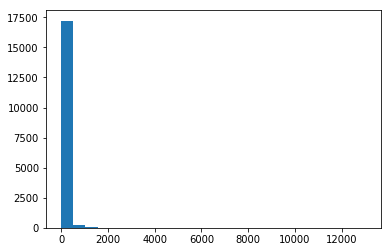

In [24]:
#Histogram of Price before trimming outliers. 
#The majority of values are below $500 but a handful go up to $12,000/night. 
plt.hist(abb_list['price'], bins=25)
plt.show()

## Inspecting Outliers - maximum_nights

In [25]:
abb_list[(abb_list['maximum_nights'] > abb_list['maximum_nights'].quantile(0.9))].sort_values(by='maximum_nights')

id                            listing_url  \
7430   16309682  https://www.airbnb.com/rooms/16309682   
4742   12273993  https://www.airbnb.com/rooms/12273993   
8423   17992558  https://www.airbnb.com/rooms/17992558   
225      692262    https://www.airbnb.com/rooms/692262   
7339   16172347  https://www.airbnb.com/rooms/16172347   
185      573892    https://www.airbnb.com/rooms/573892   
11041  20953519  https://www.airbnb.com/rooms/20953519   
352     1033162   https://www.airbnb.com/rooms/1033162   
6617   14994417  https://www.airbnb.com/rooms/14994417   
3158    7932790   https://www.airbnb.com/rooms/7932790   
4951   12869281  https://www.airbnb.com/rooms/12869281   
2425    6692626   https://www.airbnb.com/rooms/6692626   
5283   13379170  https://www.airbnb.com/rooms/13379170   
3656    9229023   https://www.airbnb.com/rooms/9229023   
576     1704187   https://www.airbnb.com/rooms/1704187   
321      954475    https://www.airbnb.com/rooms/954475   
3398    8499511   https://www.airbnb.com/rooms/8499511   
1313    4195081   https://www.airbnb.com/rooms/4195081   
1235    4003510   https://www.airbnb.com/rooms/4003510   
2460    6731268   https://www.airbnb.com/rooms/6731268   
2738    7033628   https://www.airbnb.com/rooms/7033628   
4377   11238363  https://www.airbnb.com/rooms/11238363   
3706    9331921   https://www.airbnb.com/rooms/9331921   
42       146601    https://www.airbnb.com/rooms/146601   
5785   13958556  https://www.airbnb.com/rooms/13958556   
11003  20919586  https://www.airbnb.com/rooms/20919586   
10573  20585992  https://www.airbnb.com/rooms/20585992   
11484  21310846  https://www.airbnb.com/rooms/21310846   
1734    5335183   https://www.airbnb.com/rooms/5335183   
4870   12655922  https://www.airbnb.com/rooms/12655922   
1195    3932510   https://www.airbnb.com/rooms/3932510   
6038   14214990  https://www.airbnb.com/rooms/14214990   
11262  21113365  https://www.airbnb.com/rooms/21113365   
3216    8048745   https://www.airbnb.com/rooms/8048745   
186      578210    https://www.airbnb.com/rooms/578210   
8249   17699190  https://www.airbnb.com/rooms/17699190   
1251    4030756   https://www.airbnb.com/rooms/4030756   
985     3302679   https://www.airbnb.com/rooms/3302679   
7909   17161313  https://www.airbnb.com/rooms/17161313   
3074    7747861   https://www.airbnb.com/rooms/7747861   
2961    7382746   https://www.airbnb.com/rooms/7382746   
3018    7557710   https://www.airbnb.com/rooms/7557710   
628     1885950   https://www.airbnb.com/rooms/1885950   
1974    5923285   https://www.airbnb.com/rooms/5923285   
4868   12655272  https://www.airbnb.com/rooms/12655272   
4488   11587757  https://www.airbnb.com/rooms/11587757   
6688   15098430  https://www.airbnb.com/rooms/15098430   
1252    4030789   https://www.airbnb.com/rooms/4030789   
621     1869711   https://www.airbnb.com/rooms/1869711   

                                             picture_url  host_response_time  \
7430   https://a0.muscache.com/im/pictures/39e697fb-7...      within an hour   
4742   https://a0.muscache.com/im/pictures/bb1eb3dd-c...      within an hour   
8423   https://a0.muscache.com/im/pictures/143752ea-e...      within an hour   
225    https://a0.muscache.com/im/pictures/9569447/4c...  within a few hours   
7339   https://a0.muscache.com/im/pictures/08d744be-d...      within an hour   
185    https://a0.muscache.com/im/pictures/60047477/c...      within an hour   
11041  https://a0.muscache.com/im/pictures/5fdaf203-2...      within an hour   
352    https://a0.muscache.com/im/pictures/17156028/5...      within an hour   
6617   https://a0.muscache.com/im/pictures/0fdfec83-2...      within an hour   
3158   https://a0.muscache.com/im/pictures/101069025/...  within a few hours   
4951   https://a0.muscache.com/im/pictures/415f9feb-7...        within a day   
2425   https://a0.muscache.com/im/pictures/84421342/6...  within a few hours   
5283   https://a0.muscache.com/im/pictures/4854c978-0...      within an 

Looking at the high values for maximum_nights, some of them seem nonsensical ('999999999', '2147483647', for example). I am not sure how this field is collected but I don't believe it would have much predictive power so I will remove it completely. 

In [26]:
abb_list.drop(columns='maximum_nights', axis=1, inplace=True)

In [27]:
#Drop records with price, security deposit, cleaning fee outliers 
#... (defined as outside 3 standard deviations from mean)
abb_list = abb_list[np.abs(abb_list['price'] - abb_list['price'].mean()) 
                    <= (3 * abb_list['price'].std())]

abb_list = abb_list[np.abs(abb_list['security_deposit'] - abb_list['security_deposit'].mean()) 
                    <= (3 * abb_list['security_deposit'].std())]

abb_list = abb_list[np.abs(abb_list['cleaning_fee'] - abb_list['cleaning_fee'].mean()) 
                    <= (3 * abb_list['cleaning_fee'].std())]


In [28]:
abb_list.describe(percentiles=[.01, .1, .5, .9, .99])

id  host_response_rate      latitude     longitude  \
count  1.694700e+04        16947.000000  16947.000000  16947.000000   
mean   1.683854e+07           74.393403     43.678817    -79.397152   
std    7.555837e+06           41.110348      0.047331      0.060960   
min    1.419000e+03            0.000000     43.586713    -79.624535   
1%     5.723766e+05            0.000000     43.613296    -79.564485   
10%    5.440949e+06            0.000000     43.640171    -79.462781   
50%    1.846290e+07          100.000000     43.661973    -79.397736   
90%    2.610800e+07          100.000000     43.766937    -79.322856   
99%    2.746196e+07          100.000000     43.808833    -79.211851   
max    2.758201e+07          100.000000     43.847487    -79.127812   

       accommodates     bathrooms      bedrooms          beds         price  \
count  16947.000000  16947.000000  16947.000000  16947.000000  16947.000000   
mean       2.978462      1.205494      1.262406      1.610256    124.899333   
std        1.782906      0.475849      0.769264      0.975649     94.098612   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
1%         1.000000      1.000000      0.000000      1.000000     25.000000   
10%        1.000000      1.000000      1.000000      1.000000     42.000000   
50%        2.000000      1.000000      1.000000      1.000000    100.000000   
90%        5.000000      2.000000      2.000000      3.000000    239.000000   
99%        9.000000      3.000000      4.000000      5.000000    500.000000   
max       16.000000      6.500000      8.000000     16.000000    850.000000   

       security_deposit  cleaning_fee  guests_included  extra_people  \
count      16947.000000  16947.000000     16947.000000  16947.000000   
mean         201.967015     42.213725         1.590193     13.435947   
std          237.302891     37.906338         1.148763     22.026013   
min            0.000000      0.000000         1.000000      0.000000   
1%             0.000000      0.000000         1.000000      0.000000   
10%            0.000000      0.000000         1.000000      0.000000   
50%          150.000000     35.000000         1.000000      6.000000   
90%          500.000000     99.000000         3.000000     35.000000   
99%         1000.000000    150.000000         6.000000    100.000000   
max         1301.000000    170.000000        16.000000    392.000000   

       minimum_nights  availability_30  availability_60  availability_90  \
count    16947.000000     16947.000000     16947.000000     16947.000000   
mean         5.888712         6.770225        17.911902        32.264708   
std         25.148324         8.789496        19.363014        31.024667   
min          1.000000         0.000000         0.000000         0.000000   
1%           1.000000         0.000000         0.000000         0.000000   
10%          1.000000         0.000000         0.000000         0.000000   
50%          2.000000         3.000000        10.000000        26.000000   
90%          7.000000        22.000000        50.000000        79.000000   
99%         90.000000        30.000000        60.000000        90.000000   
max       1125.000000        30.000000        60.000000        90.000000   

       availability_365  reviews_per_month  
count      16947.000000       16947.000000  
mean         122.782321           1.612150  
std          127.509917           2.090342  
min            0.000000           0.000000  
1%             0.000000           0.000000  
10%            0.000000           0.000000  
50%           72.000000           0.800000  
90%          336.400000           4.540000  
99%          365.000000           9.090000  
max          365.000000          16.860000

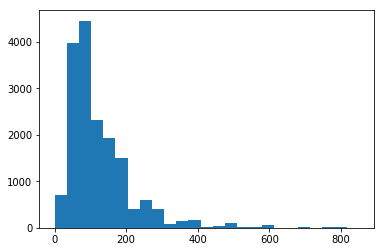

In [29]:
#Histogram of Price after trimming outliers. 
plt.hist(abb_list['price'], bins=25)
plt.show()

## Handling Outliers Functionally

In [30]:
def winsorize_outliers(data):
    
    quantiles = data.quantile([0.05, 0.95])
    q_05 = quantiles.loc[0.05]
    q_95 = quantiles.loc[0.95]

    out = np.where(data.values <= q_05, q_05,
                   np.where(data >= q_95, q_95, data))
    
    return out

In [31]:
#Trim accomodates, bathrooms, bedrooms, beds, guests_included, extra_people, minimum_nights to the 99th percentiles
cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'extra_people', 'minimum_nights']
abb_list[cols] = abb_list[cols].apply(winsorize_outliers)

In [32]:
abb_list.describe(percentiles=[.01, .1, .5, .9, .99])

id  host_response_rate      latitude     longitude  \
count  1.694700e+04        16947.000000  16947.000000  16947.000000   
mean   1.683854e+07           74.393403     43.678817    -79.397152   
std    7.555837e+06           41.110348      0.047331      0.060960   
min    1.419000e+03            0.000000     43.586713    -79.624535   
1%     5.723766e+05            0.000000     43.613296    -79.564485   
10%    5.440949e+06            0.000000     43.640171    -79.462781   
50%    1.846290e+07          100.000000     43.661973    -79.397736   
90%    2.610800e+07          100.000000     43.766937    -79.322856   
99%    2.746196e+07          100.000000     43.808833    -79.211851   
max    2.758201e+07          100.000000     43.847487    -79.127812   

       accommodates     bathrooms      bedrooms          beds         price  \
count  16947.000000  16947.000000  16947.000000  16947.000000  16947.000000   
mean       2.878917      1.178144      1.239157      1.582286    124.899333   
std        1.475748      0.362368      0.687674      0.850018     94.098612   
min        1.000000      1.000000      0.000000      1.000000      0.000000   
1%         1.000000      1.000000      0.000000      1.000000     25.000000   
10%        1.000000      1.000000      1.000000      1.000000     42.000000   
50%        2.000000      1.000000      1.000000      1.000000    100.000000   
90%        5.000000      2.000000      2.000000      3.000000    239.000000   
99%        6.000000      2.000000      3.000000      4.000000    500.000000   
max        6.000000      2.000000      3.000000      4.000000    850.000000   

       security_deposit  cleaning_fee  guests_included  extra_people  \
count      16947.000000  16947.000000     16947.000000  16947.000000   
mean         201.967015     42.213725         1.529474     12.160795   
std          237.302891     37.906338         0.901303     15.231025   
min            0.000000      0.000000         1.000000      0.000000   
1%             0.000000      0.000000         1.000000      0.000000   
10%            0.000000      0.000000         1.000000      0.000000   
50%          150.000000     35.000000         1.000000      6.000000   
90%          500.000000     99.000000         3.000000     35.000000   
99%         1000.000000    150.000000         4.000000     50.000000   
max         1301.000000    170.000000         4.000000     50.000000   

       minimum_nights  availability_30  availability_60  availability_90  \
count    16947.000000     16947.000000     16947.000000     16947.000000   
mean         3.700006         6.770225        17.911902        32.264708   
std          5.566762         8.789496        19.363014        31.024667   
min          1.000000         0.000000         0.000000         0.000000   
1%           1.000000         0.000000         0.000000         0.000000   
10%          1.000000         0.000000         0.000000         0.000000   
50%          2.000000         3.000000        10.000000        26.000000   
90%          7.000000        22.000000        50.000000        79.000000   
99%         25.000000        30.000000        60.000000        90.000000   
max         25.000000        30.000000        60.000000        90.000000   

       availability_365  reviews_per_month  
count      16947.000000       16947.000000  
mean         122.782321           1.612150  
std          127.509917           2.090342  
min            0.000000           0.000000  
1%             0.000000           0.000000  
10%            0.000000           0.000000  
50%           72.000000           0.800000  
90%          336.400000           4.540000  
99%          365.000000           9.090000  
max          365.000000          16.860000

## Saving cleaned file for easy access

In [33]:
#Check shape, make sure it matches expectations
abb_list.shape

(16947, 53)

In [34]:
abb_list.to_csv('../Capstone/Data/listings_clean.csv', index=False)

Now that nulls and outliers have been taken care of in the AirBnB dataset, it is time to turn my attention to the Yelp dataset, which thankfully has fewer variables in need of wrangling. 

# Yelp Dataset Analysis

## Read in Data

Next I will open the Yelp dataset. This data comes from Yelp's Academic dataset, found here: https://www.yelp.com/dataset. The data is made available by Yelp in JSON format. I plan to use this dataset to find the average review rating and number of businesses of various types in the vicinity of Toronto AirBnB listings. 

In [35]:
#Read in Yelp Business dataset
path='../Capstone/Data/yelp_academic_dataset_business.json'
yelp_df = pd.read_json(path, lines=True, encoding='utf-8')

In [36]:
print(yelp_df.shape)
print("")
print(yelp_df.info())

(188593, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188593 entries, 0 to 188592
Data columns (total 15 columns):
address         188593 non-null object
attributes      162807 non-null object
business_id     188593 non-null object
categories      188052 non-null object
city            188593 non-null object
hours           143791 non-null object
is_open         188593 non-null int64
latitude        188587 non-null float64
longitude       188587 non-null float64
name            188593 non-null object
neighborhood    188593 non-null object
postal_code     188593 non-null object
review_count    188593 non-null int64
stars           188593 non-null float64
state           188593 non-null object
dtypes: float64(3), int64(2), object(10)
memory usage: 21.6+ MB
None


The Yelp dataset has 188,593 rows and 15 columns. 

In [37]:
yelp_df.head()

address                                         attributes  \
0    1314 44 Avenue NE  {'BikeParking': 'False', 'BusinessAcceptsCredi...   
1                       {'Alcohol': 'none', 'BikeParking': 'False', 'B...   
2  1335 rue Beaubien E  {'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...   
3      211 W Monroe St                                               None   
4  2005 Alyth Place SE             {'BusinessAcceptsCreditCards': 'True'}   

              business_id                                         categories  \
0  Apn5Q_b6Nz61Tq4XzPdf9A  Tours, Breweries, Pizza, Restaurants, Food, Ho...   
1  AjEbIBw6ZFfln7ePHha9PA  Chicken Wings, Burgers, Caterers, Street Vendo...   
2  O8S5hYJ1SMc8fA4QBtVujA  Breakfast & Brunch, Restaurants, French, Sandw...   
3  bFzdJJ3wp3PZssNEsyU23g                      Insurance, Financial Services   
4  8USyCYqpScwiNEb58Bt6CA  Home & Garden, Nurseries & Gardening, Shopping...   

        city                                              hours  is_open  \
0    Calgary  {'Monday': '8:30-17:0', 'Tuesday': '11:0-21:0'...        1   
1  Henderson  {'Friday': '17:0-23:0', 'Saturday': '17:0-23:0...        0   
2   Montréal  {'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...        0   
3    Phoenix                                               None        1   
4    Calgary  {'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...        1   

    latitude   longitude                  name               neighborhood  \
0  51.091813 -114.031675  Minhas Micro Brewery                              
1  35.960734 -114.939821   CK'S BBQ & Catering                              
2  45.540503  -73.599300         La Bastringue  Rosemont-La Petite-Patrie   
3  33.449999 -112.076979       Geico Insurance                              
4  51.035591 -114.027366         Action Engine                              

  postal_code  review_count  stars state  
0     T2E 6L6            24    4.0    AB  
1       89002             3    4.5    NV  
2     H2G 1K7             5    4.0    QC  
3       85003             8    1.5    AZ  
4     T2H 0N5             4    2.0    AB

## Inspect Cities and Narrow to Toronto

I can see there are multiple cities in this dataset. I only care about Toronto, so before doing any further analysis I plan to limit the dataset. First I will check and confirm Toronto is actually in the data.

In [38]:
#View list of cities
list(yelp_df.city.unique())

['Calgary',
 'Henderson',
 'Montréal',
 'Phoenix',
 'Toronto',
 'Mississauga',
 'Avondale',
 'Pittsburgh',
 'Markham',
 'Las Vegas',
 'Cleveland',
 'Monticello',
 'Streetsboro',
 'Sun Prairie',
 'Cave Creek',
 'Middlefield',
 'Medina',
 'Gilbert',
 'Upper St Clair',
 'Avalon',
 'North York',
 'Monroeville',
 'Concord',
 'Charlotte',
 'Tolleson',
 'Mesa',
 'Kent',
 'South Euclid',
 'Surprise',
 'Scottsdale',
 'Woodbridge',
 'Thornhill',
 'Tempe',
 'Gastonia',
 'North Las Vegas',
 'Rocky River',
 'Glendale',
 'Richmond Hill',
 'North Randall',
 'Peoria',
 'Richfield',
 'Laval',
 'Brooklyn',
 'Garfield Heights',
 'Landau',
 'las vegas',
 'Goodyear',
 'Mentor',
 'Amherst',
 'Matthews',
 'Chagrin Falls',
 'Montreal',
 'Ajax',
 'Laveen Village',
 'Etobicoke',
 'Lakewood',
 'Scarborough',
 'Madison',
 'Oakville',
 'Stouffville',
 'Chandler',
 'Monroe',
 'Pleasant Hills',
 'Brunswick',
 'Fountain Hills',
 'East Gwillimbury',
 'Mount Holly',
 'Longueuil',
 'Fort Mill',
 'Swissvale',
 'Litchfiel

There are too many cities to view this way, instead I will look for the top 10 cities in the dataset

In [39]:
city_count = yelp_df['city'].value_counts().to_frame().reset_index().sort_values('city', ascending=False)
city_count.head(10)

index   city
0   Las Vegas  28865
1     Phoenix  18633
2     Toronto  18233
3   Charlotte   9204
4  Scottsdale   8822
5     Calgary   7384
6  Pittsburgh   6804
7        Mesa   6239
8    Montréal   6045
9   Henderson   4815

Toronto appears to be the third largest city in the dataset in terms of number of businesses. 18,233 records should be plenty for my analysis. Next I will limit the dataset by filtering out all other cities. 

In [40]:
yelp_df = yelp_df[yelp_df['city'] == 'Toronto']
yelp_df.shape

(18233, 15)

I also know I can limit the results by removing businesses that are no longer open using the is_open variable. If the value is 0 it means the business is closed. Dropping closed businesses leaves me with 14,023 records.

In [41]:
yelp_df = yelp_df[yelp_df['is_open'] == 1]
yelp_df.shape

(14023, 15)

## Drop Uneccessary Columns

Next I will remove columns that I do not plan to use in my analysis. My goal is to end up with the count of businesses and average star rating in a given area. 

To that end I believe I can safely drop address (I have neighborhood and latitude/longitude to join on), attributes, categories, city, hours, is_open, name, postal_code, and state. 

In [42]:
#Drop unecessary columns
cols = ['attributes', 'address', 'categories', 'city', 'hours', 'is_open', 'name', 'postal_code', 'state']
yelp_df.drop(columns=cols, axis=1, inplace=True)
yelp_df.shape

(14023, 6)

## Check for Null Values

In [43]:
null_rates = (1 - yelp_df.count()/len(yelp_df.index)) * 100
print(null_rates[null_rates > 0].sort_values(ascending=False))
print("")
print("Columns with at least one null value: " + str(null_rates[null_rates > 0].count()))

Series([], dtype: float64)

Columns with at least one null value: 0


Checking for nulls using the same method I used on the AirBnB dataset finds no null values. However I remember from inspecting the first few rows that there are some null values, at least in the neighborhood column. Here it is again. This leads me to believe there are null values, but possibly encoded with a space so they don't register as nulls. 

In [44]:
yelp_df.head()

business_id   latitude  longitude           neighborhood  \
23  5J3b7j3Fzo9ISjChmoUoUA  43.681328 -79.427884               Wychwood   
43  zHwXoh40k86P0aiN1aix9Q  43.733395 -79.224206            Scarborough   
51  wv9KN5x8L2qzKFq_6Hzf9g  43.661964 -79.391259     Discovery District   
69  RJEtBRLJmmji_QoqS6ysjg  43.667749 -79.396167  University of Toronto   
80  YIez_A3WOt9J2SXN7OMa2Q  43.745928 -79.324623                          

    review_count  stars  
23            23    4.0  
43             3    2.0  
51             3    4.5  
69             3    4.5  
80           105    4.0

In [45]:
print(yelp_df['neighborhood'].value_counts(dropna=False).head(10))

                                 2842
Downtown Core                    1317
Scarborough                       717
Etobicoke                         601
Yorkville                         419
Entertainment District            351
The Danforth                      305
Leslieville                       299
Yonge and Eglinton                292
Mount Pleasant and Davisville     280
Name: neighborhood, dtype: int64


We can see that the most frequent neighborhood value is blank, with 2,842 records. This is around 20% of the remianing dataset! This is a problem because my plan was to first join this dataset with AirBnB on neighborhood, then look for businesses within a certain radius based on latitude and longitude. With these 2,842 records I will need to compare lat/long against the entire Yelp dataset, which will be more time-consuming. However I do not want to lose these records, so for now I will keep them and replace the blank with "Unknown". 

In [46]:
yelp_df['neighborhood'].replace("", "Unknown", inplace=True)

#Check again and confirm "" has been replaced by "Unknown"
print(yelp_df['neighborhood'].value_counts(dropna=False).head(3))

Unknown          2842
Downtown Core    1317
Scarborough       717
Name: neighborhood, dtype: int64


Next I will double-check the remaining fields. Business_id is a text field so I will check it's value counts. Ideally no value should have more than 1 count since it is an ID variable. 

In [47]:
print(yelp_df['business_id'].value_counts(dropna=False).head())

DYGCzsHi7pT4AAe8kh5Dug    1
8aeJ9sx4cfpUgOp3g8eeyQ    1
8idRgzKzCZ2l2_d7nUSQDQ    1
0HIiowOQJgs46UL8Vt3lsQ    1
OFAiA6En2HD0CqLkFDCNpg    1
Name: business_id, dtype: int64


Finally I will check the numeric variables using the describe() method. This also shows no missing values for the remaining fields.

I can also see the only field with outliers is review_count. However I plan to group this variable before using in predictions so I will leave the outliers. 

In [48]:
yelp_df.describe()

latitude     longitude  review_count         stars
count  14023.000000  14023.000000  14023.000000  14023.000000
mean      43.675462    -79.393396     28.377095      3.505063
std        0.447928      0.242271     62.355419      0.962225
min       -9.095137    -80.623297      3.000000      1.000000
25%       43.650503    -79.419837      4.000000      3.000000
50%       43.664531    -79.393570      8.000000      3.500000
75%       43.691834    -79.374978     25.000000      4.000000
max       45.028731    -51.833829   1837.000000      5.000000

## Save Cleaned File for Easy Access

In [49]:
yelp_df.to_csv('../Capstone/Data/yelp_clean.csv', index=False)